# <center> **UBC Simulation** </center>
---

The goal of this project is to investigate the properties of a specific type of synapses in the cerebellum: between **mossy fibers (MF)** and **unipolar brush cells (UBCs)**. 

These synapses are interesting because they feature remarkably large dimensions, with numerous neurotransmitter release sites.
They could potentially play a role in the transformation of the sensory signal encoding acceleration. More precisely, they could act like filters, leading to the temporal integration of the signal. This process would be a step to convert the sensory detection of acceleration into the cognitive perception of movement.

The aim of this modeling is thus to assess the effects of the **morphology** of a synapse on the **signal transmission**.

 ---
 
*All the modules and functions provided in the project are documented, and accessible through help().*


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import UBC_synapse as UBC

help(UBC)

UBC_synapse importation:
synapse successfully imported
simulate successfully imported
visualize successfully imported
manage_data successfully imported
patterns_release successfully imported
Help on package UBC_synapse:

NAME
    UBC_synapse - Modeling of synapses between mossy fibers and unipolar brush cells (UBCs) in the cerebellum.

DESCRIPTION
    The goal of this modeling is to investigate the properties of a specific type of synapses in the cerebellum: between mossy fibers (MF) and unipolar brush cells (UBCs).
    More precisely, it consists in assessing the effects of the morphology of a synapse on the signal transmission.
    For this purpose, the package achieves the following tasks:
        1. Modeling the morphology of synapses.
        2. Simulating their behavior in response to a stimulation pattern (events of glutamate release).
    
    Usage
    -------
    The Jupyter notebook provided in the package is designed to guide the user in the exploration of the functionaliti

## I - Determination of parameters
---

The main parameter assumed to influence the signal transmission is the **diameter of the glomerule** (synaptic surface). Analysig its effects requires to test the behavior of different synapses with various diameters, while keeping the other parameters fixed.
A first step in building this model consists in determining appropriate ranges of parameters. Namely, the following parameters have to be set:
- the range of the diameters: `dim_list`,
- the number of sites for neurotransmitter release: `n_sites`,
- the cumulative area of neurotransmitter realease: `area_tot_sites`.

A first criteria to chose those values is their matching as much as possible the physiological parameters. Some of them have been measured experimentally:
- diameters of the synapses: between 200 and 1000 µm,
- cumulative release area: 12 - 40 µm² (given by Mugni).

A second criteria for the parameters' values is their convenience for modeling constraints. The synapse is modelled by a circular matrix. The release sites are homogenousely distributed on this area, according to a hexagonal grid. These properties impose some geometric relations between the spatial parameters.

#### 1. Determination of `n_sites` and `dim_min`

Let us chose `area_tot_sites = 25e-12 m²`, and try several values for `n_sites`.
The function called below automatically computes an appropriate value for `dim`, in order to match the geometric constraints of the hexagonal grid.

Different values for `n_sites` lead to different shapes of synapses. More precisely, the synapses differ regarding the spatial distribution of the release sites, and the individual sites' shape.
From the results shown below, it seems acceptable to chose `n_sites = 37`.
In that case, the minimal dimension for the glomerule is `dim_min = 43`.

For bluiding a hexgrid, the closest possible value for n_sites is 37.
Release area updated with this parameter: 2.5159999999999997e-11 m^2.
Area of a single site: 3.3999999999999996e-06 m^2 (17 px).
Diameter obtained for the glomerulus: 8.599999999999999e-06 m = 85.99999999999999 um (43 px).


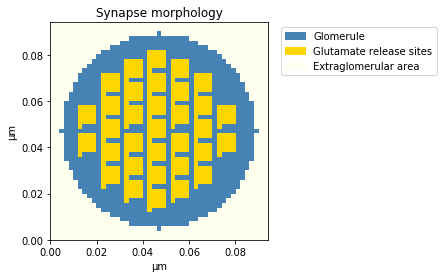

For bluiding a hexgrid, the closest possible value for n_sites is 55.
Release area updated with this parameter: 2.6399999999999997e-11 m^2.
Area of a single site: 2.4e-06 m^2 (12 px).
Diameter obtained for the glomerulus: 8.599999999999999e-06 m = 85.99999999999999 um (43 px).


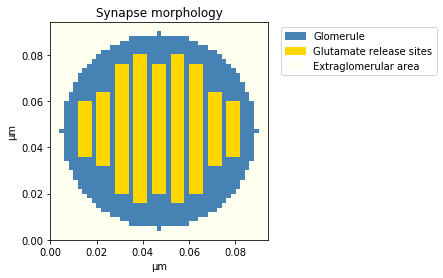

For bluiding a hexgrid, the closest possible value for n_sites is 61.
Release area updated with this parameter: 2.6839999999999995e-11 m^2.
Area of a single site: 2.2e-06 m^2 (11 px).
Diameter obtained for the glomerulus: 8.599999999999999e-06 m = 85.99999999999999 um (43 px).


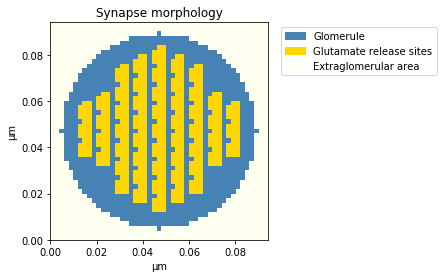

In [2]:
area_tot_sites = 25e-12
# Instanciation of synapses with different numbers of sites:
for n_sites in [35, 50, 60] :
    syn = UBC.Synapse(n_sites=n_sites, area_tot_sites=area_tot_sites, verbose=True)
    syn.visualize_synapse()

#### 2. Determination of a range of dimensions to test 

Let us now try the several values for `dim`, keeping `n_sites` fixed to `37`. 

The dimensions tested below, `[40, 80, 130]`, will be adjested by the function in order to yield more convenient final dimensions.

From the results shown below, it seems that choosing `dim_list = [43, 79, 115]` enables to asses synapses with noticeable differences, which is the aim of the analysis.

Number of release sites: 37.
Release area updated with this parameter: 2.5159999999999997e-11 m^2.
Area of a single site: 3.3999999999999996e-06 m^2 (17 px).
Diameter obtained for the glomerulus: 8.599999999999999e-06 m = 85.99999999999999 um (43 px).


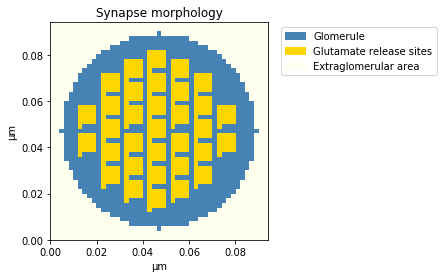

Number of release sites: 37.
Release area updated with this parameter: 2.5159999999999997e-11 m^2.
Area of a single site: 3.3999999999999996e-06 m^2 (17 px).
Diameter obtained for the glomerulus: 1.5799999999999998e-05 m = 157.99999999999997 um (79 px).


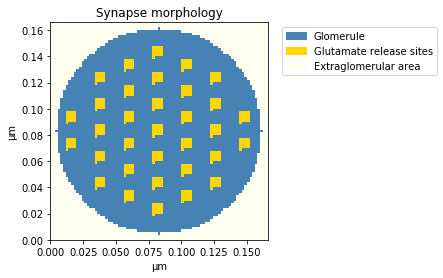

Number of release sites: 37.
Release area updated with this parameter: 2.5159999999999997e-11 m^2.
Area of a single site: 3.3999999999999996e-06 m^2 (17 px).
Diameter obtained for the glomerulus: 2.3e-05 m = 230.0 um (115 px).


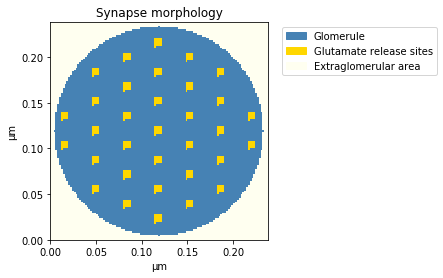

Final dimensions: [43, 79, 115]


In [3]:
n_sites = 37
dim_list = [40, 80, 130]

# Diameters that will be optimized by the function:
final_dims = []

# Instanciation of synapses with testing different diameters:
for dim in dim_list :
    syn = UBC.Synapse(n_sites=n_sites, dim=dim, area_tot_sites=area_tot_sites, verbose=True)
    final_dims.append(syn.dim)
    syn.visualize_synapse()

print("Final dimensions: {}".format(final_dims))

## II. Generation of stimulation patterns
---

Now that several synapses have been selected, the next step is to investigate their behavior. For this purpose, they can be submitted to different **stimulation patterns**. 

A stimulation pattern is a sequence of spikes of the presynaptic neuron (mossy fiber). It describes, in time, the events of glutamate release. Different types of patterns can be tested.

#### 1. "Experimental stimulation" patterns

Those patterns consist in one or several spike events (burst), at a fixed frequency. 

This type of patterns is meant to validate the model, by comparing the shape of the computed responses to real neurons' responses recorded on under artifical stimulation.

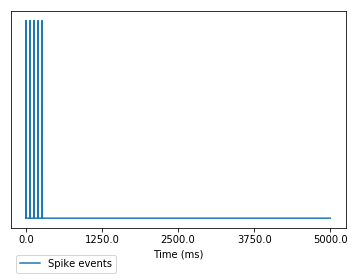

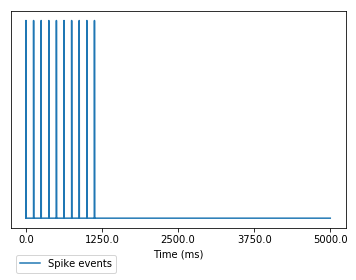

In [4]:
patt = UBC.Pattern(mode='stim', n_stim=5, dur=0.5, f_stim=150)
patt.visualize_patt()

patt = UBC.Pattern(mode='stim', n_stim=10, dur=0.5, f_stim=80)
patt.visualize_patt()

#### 2. "Oscillatory" patterns

Those patterns consist in continuous firing, whose frequency follows a sinusoidal variation. 

This type of pattern is closer to the in vivo firings of the pre-synaptic neurons. It is the overall variation of firing frequency which constitutes the "signal".

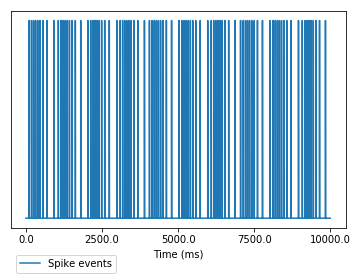

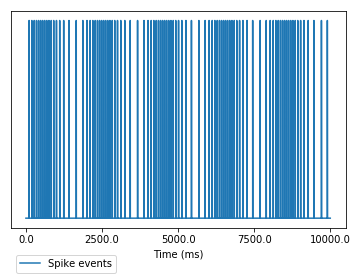

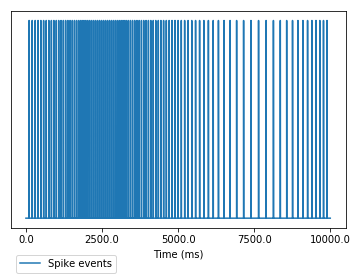

In [5]:
patt = UBC.Pattern(mode='oscill', fenv=10)
patt.visualize_patt()
patt = UBC.Pattern(mode='oscill', fenv=5)
patt.visualize_patt()
patt = UBC.Pattern(mode='oscill', fenv=1)
patt.visualize_patt()

## III. Generating simulations data
---

Henceforth, let us take a look at the synapse behavior under a stimulation pattern. A **response** features several components:
1. The evolution of the **neurotransmitter concentrations(glutamate)** in the synapse. Its variations can be recorder at different locations on the glomerule, to investigate local inhomogeneities (between release sites and non-release areas, between the synapse center and the periphery). The evolution of the glutamate concentration in one voxel is determined by diffusion equations (Fick's laws in discrete time).
2. The activation state of the post-synaptic **AMPA receptor**. The AMPA receptor is a ionic channel, whose opening triggers the membrane depolarization. At each moment, the receptor takes one state among those three: open, closed, or desensitised. The probability of being in a state depends on the local concentration of glutamate. At each time, the overall activation in the population of AMPA receptors (at the whole synapse level) is measured by computing the proportion of AMPA receptors in the open state.
3. The variations of the post-synaptic **membrane potential**. The depolarization of the UBC depends on the total current intering through its AMPA receptors. The variations of the membrane potential represent the signal transmitted in the post-synaptic neuron.

#### 1. Stimulating a synapse with a pattern

Below is provided an example of procedure in several steps.

1. Instanciation of a dictionary of synapses of various diameters.
2. Generation of a pattern.
3. Running a simulation with this pattern on the synapses.
4. Saving the results for future analyses.

The project folder contains a directory `UBC_data/` meant to store the results of the computations. If this notebook is run for the first time, the folder is empty for now. During the process, it will be filled with nested sub-directories, corresponding to the different synapses and their responses. Registers will also be created, in order to keep track of all synapses and responses saved.

In [6]:
n_sites = 37
dim_list = [43, 79, 130]
# 1. Dictionary of synapses objects:
syn = UBC.Synapse.instantiate(dim_list=dim_list, n_sites=n_sites) 
# 2. Pattern:
patt = UBC.Pattern(mode='stim')

Synapses instanciated: dict_keys(['43', '79', '115'])


For instance, running the first simulation with the smallest synapse (`syn['743']`) will instantiate a directory for registering all the future synapses. 

In this file, a line summarizes the properties of `syn['43']`, and attributes it an index (`0`). This index allows to refer to the synapse directory `syn0/`, containing the responses obtained with this synapse. 

Likewise, inside the directory `syn0/`, each response is registered under an index, reported in a file, which points to the sub-directory containing the time series.

In [7]:
# 3. Simulation:
syn['43'].simulate_stimulation(patt)
# 4. Saving:
syn['43'].save_response()

Running the simulation. It may take some time.
Simulation completed.
Creating a register at /media/esther/Données/Travail/Stages/PCBS_UBC_synapse/UBC_data/synapses_register.csv.
Creating a directory at /media/esther/Données/Travail/Stages/PCBS_UBC_synapse/UBC_data/syn0
Creating a register at /media/esther/Données/Travail/Stages/PCBS_UBC_synapse/UBC_data/syn0/responses_syn0_register.csv.
Creating a directory at /media/esther/Données/Travail/Stages/PCBS_UBC_synapse/UBC_data/syn0/resp0_syn0
Saved: response at index 0 for synapse 0.


This procedure can be reproduced for `syn['79']` and `syn['115']`, leading to appending new lines in `register_syn.csv`. It also creates new sub-foders `syn1/` and `syn2/`, including the respective sub-directories for their responses.

*Please wait about 2 minutes so that the computations could complete.*

In [8]:
syn['79'].simulate_stimulation(patt)
syn['79'].save_response()
syn['115'].simulate_stimulation(patt)
syn['115'].save_response()

found, register_syns = UBC.Synapse.search_synapses()
register_syns

Running the simulation. It may take some time.
Simulation completed.
Creating a directory at /media/esther/Données/Travail/Stages/PCBS_UBC_synapse/UBC_data/syn1
Creating a register at /media/esther/Données/Travail/Stages/PCBS_UBC_synapse/UBC_data/syn1/responses_syn1_register.csv.
Creating a directory at /media/esther/Données/Travail/Stages/PCBS_UBC_synapse/UBC_data/syn1/resp0_syn1
Saved: response at index 0 for synapse 1.
Running the simulation. It may take some time.
Simulation completed.
Creating a directory at /media/esther/Données/Travail/Stages/PCBS_UBC_synapse/UBC_data/syn2
Creating a register at /media/esther/Données/Travail/Stages/PCBS_UBC_synapse/UBC_data/syn2/responses_syn2_register.csv.
Creating a directory at /media/esther/Données/Travail/Stages/PCBS_UBC_synapse/UBC_data/syn2/resp0_syn2
Saved: response at index 0 for synapse 2.
Indexes of found synapses:[0, 1, 2]


,Index,dim,n_sites,area_tot_sites,res,border_intra,border_extra,N_AMPA,G_AMPA,E_AMPA,V0,R,C
0,0,43,37,2.516000e-11,2.000000e-07,2,2,3,2.000000e-11,0,-0.075,652000000,1.700000e-11
1,1,79,37,2.516000e-11,2.000000e-07,2,2,3,2.000000e-11,0,-0.075,652000000,1.700000e-11
2,2,115,37,2.516000e-11,2.000000e-07,2,2,3,2.000000e-11,0,-0.075,652000000,1.700000e-11


It is also possible to save various responses for the same synapse.

In [9]:
patt2 = UBC.Pattern(mode='stim', n_stim=2, dur=0.005, f_stim=500)
syn['43'].simulate_stimulation(patt2)
syn['43'].save_response()

found, register_responses = syn['43'].search_responses()
register_responses

Running the simulation. It may take some time.
Simulation completed.
Creating a directory at /media/esther/Données/Travail/Stages/PCBS_UBC_synapse/UBC_data/syn0/resp1_syn0
Saved: response at index 1 for synapse 0.
Indexes of found responses for this synapse:[0, 1]


,Index,mode,tstep,dur,nit,start,n_stim,f_stim,fenv,fmin,fmax
0,0,stim,1.000000e-07,0.002,20000,1000,1,100,NaN,NaN,NaN
1,1,stim,1.000000e-07,0.005,50000,1000,2,500,NaN,NaN,NaN


#### 2. Loading previousely saved data

For further analysis with multiple syapses, it could be useful to retrieve a previousely saved synapse and a particular response.

The register of all synapses and the register of a synapse's responses can be filtered according to specific criteria.
For instance, a synapse with a specific diameter of interest can be recovered. 
Then, a response featuring can one single stimulation spike can be looked for in the synapse register of responses.

In [10]:
found_syn, _ = UBC.Synapse.search_synapses(dim=43)
syn_backup = UBC.Synapse.retrieve_synapse(found_syn[0])
print(syn_backup)

found_resp, _ = syn_backup.search_responses(n_stim=1)
syn_backup.retrieve_response(found_resp[0])

Indexes of found synapses:[0]
Indexes of found responses for this synapse:[0]
Response retrieved.


## IV. Visualizing the results

Below are displayed the results for two synapses for a simple stimulation event ("small": diameter 43 px, "large": diameter 115 px):
1. Evolution of the glutamate concentrations at four points of interest.
2. Evolution of proportion of the opened AMPA receptors on the overall glomerule.
3. Evolution of the membrane potential of the UBC.

These time series highlight different behaviors according to the size of the synapse. In a larger synapse, the responses are more heterogeneous between locations (center vs. periphery). The AMPA opening reaches its maximum later, which results in a delayed signal transmission.

Response retrieved.


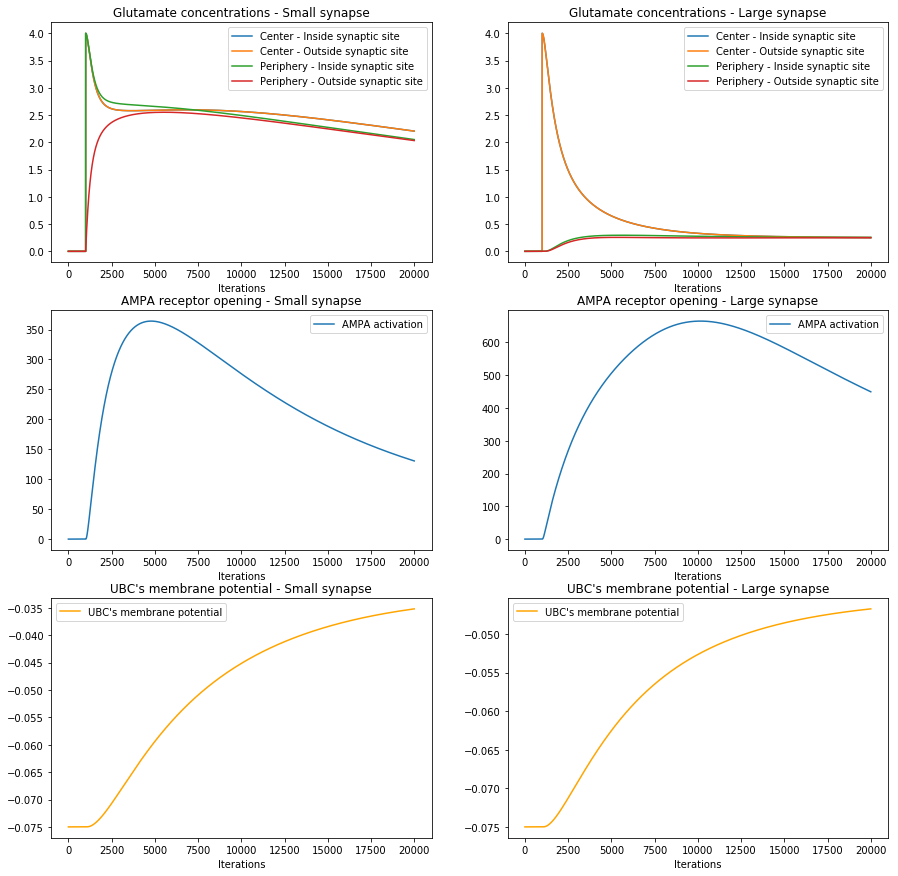

In [11]:
syn['43'].retrieve_response(0)

fig, axes = plt.subplots(3, 2, figsize=(15,15))

axes[0, 0].set_title("Glutamate concentrations - Small synapse")
axes[0, 0].plot(syn['43'].resp['glus'][0], label="Center - Inside synaptic site")
axes[0, 0].plot(syn['43'].resp['glus'][1], label="Center - Outside synaptic site")
axes[0, 0].plot(syn['43'].resp['glus'][2], label="Periphery - Inside synaptic site")
axes[0, 0].plot(syn['43'].resp['glus'][3], label="Periphery - Outside synaptic site")
axes[0, 0].set_xlabel("Iterations")
axes[0, 0].legend()

axes[1, 0].set_title("AMPA receptor opening - Small synapse")
axes[1, 0].plot(syn['43'].resp['AMPAtot'], label="AMPA activation")
axes[1, 0].set_xlabel("Iterations")
axes[1, 0].legend()

axes[2, 0].set_title("UBC's membrane potential - Small synapse")
axes[2, 0].plot(syn['43'].resp['V'], label="UBC's membrane potential", color='orange')
axes[2, 0].set_xlabel("Iterations")
axes[2, 0].legend()

axes[0, 1].set_title("Glutamate concentrations - Large synapse")
axes[0, 1].plot(syn['115'].resp['glus'][0], label="Center - Inside synaptic site")
axes[0, 1].plot(syn['115'].resp['glus'][1], label="Center - Outside synaptic site")
axes[0, 1].plot(syn['115'].resp['glus'][2], label="Periphery - Inside synaptic site")
axes[0, 1].plot(syn['115'].resp['glus'][3], label="Periphery - Outside synaptic site")
axes[0, 1].set_xlabel("Iterations")
axes[0, 1].legend()

axes[1, 1].set_title("AMPA receptor opening - Large synapse")
axes[1, 1].plot(syn['115'].resp['AMPAtot'], label="AMPA activation")
axes[1, 1].set_xlabel("Iterations")
axes[1, 1].legend()

axes[2, 1].set_title("UBC's membrane potential - Large synapse")
axes[2, 1].plot(syn['115'].resp['V'], label="UBC's membrane potential", color='orange')
axes[2, 1].set_xlabel("Iterations")
axes[2, 1].legend()

plt.show()